In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
df_2012_2017 = pd.read_excel('PINH04900_2012_2017.xlsx', decimal=",")
df_2017_2022 = pd.read_excel('PINH04900_2017_2022.xlsx', decimal=",")

In [75]:
df_2012_2022 = pd.concat([df_2012_2017, df_2017_2022])

In [76]:
df_2012_2022['datetime'] = pd.to_datetime(df_2012_2022['Data Coleta'] + ' ' + df_2012_2022['Hora Coleta'], format="%d/%m/%Y %H:%M")

In [77]:
df_2012_2022 = df_2012_2022.sort_values(by='datetime')

In [78]:
df_2012_2022_ph = df_2012_2022.loc[df_2012_2022['Parametro'] == 'pH']
df_2012_2022_coliformes = df_2012_2022.loc[df_2012_2022['Parametro'] == 'Escherichia coli**']
df_2012_2022_dbo = df_2012_2022.loc[df_2012_2022['Parametro'] == 'DBO (5, 20)']
df_2012_2022_fosforo = df_2012_2022.loc[df_2012_2022['Parametro'] == 'Fósforo Total']
df_2012_2022_nitrogenio = df_2012_2022.loc[df_2012_2022['Parametro'] == 'Nitrogênio Kjeldahl']
df_2012_2022_oxigenio = df_2012_2022.loc[df_2012_2022['Parametro'] == 'Oxigênio Dissolvido']
df_2012_2022_solidos = df_2012_2022.loc[df_2012_2022['Parametro'] == 'Sólido Total']
df_2012_2022_temperatura_agua = df_2012_2022.loc[df_2012_2022['Parametro'] == 'Temperatura da Água']
df_2012_2022_temperatura_ar = df_2012_2022.loc[df_2012_2022['Parametro'] == 'Temperatura do Ar']
df_2012_2022_turbidez = df_2012_2022.loc[df_2012_2022['Parametro'] == 'Turbidez']

In [79]:
#Fator de correção para coliformes em água

df_2012_2022_coliformes['Valor'] = df_2012_2022_coliformes['Valor'].astype(float)
df_2012_2022_coliformes['Valor'] = df_2012_2022_coliformes['Valor'].div(80)

C:\Users\felip\AppData\Local\Temp\ipykernel_18344\2880924698.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2012_2022_coliformes['Valor'] = df_2012_2022_coliformes['Valor'].astype(float)
C:\Users\felip\AppData\Local\Temp\ipykernel_18344\2880924698.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2012_2022_coliformes['Valor'] = df_2012_2022_coliformes['Valor'].div(80)


In [80]:
variacao_temperatura = []
for n in range(0, len(df_2012_2022_temperatura_agua)):
    variacao_temperatura.append(float(df_2012_2022_temperatura_agua.iloc[n]['Valor']) - float(df_2012_2022_temperatura_ar.iloc[n]['Valor']))

In [81]:
#source https://abrh.s3.sa-east-1.amazonaws.com/Sumarios/155/389fd4d85ad4ebbd09affba6bb4b0443_58521a35054135ab18138a8f37b809a6.pdf

def q9(o2):
    if (o2 > 140):
        return 47
    return 100.8 * np.exp(((o2 - 106)**2)/-3745)

def q1(cf):
    if (cf > 100000):
        return 3
    return 98.03 + (-36.45 * np.log10(cf)) + (3.138 * (np.log10(cf)**2)) + (0.06776 * (np.log10(cf)**3))

def q2(ph):
    if (ph > 12):
        return 3
    if (ph < 2):
        return 2
    return (0.05421 * (ph**((1.23*ph) - (0.09873*(ph**2))))) + 5.213

def q3(dbo):
    if (dbo > 30):
        return 2
    return 102.6 * np.exp(-0.01101 * dbo)

def q5(ft):
    if (ft > 10):
        return 1
    return 213.7 * np.exp(-1.680 * (ft**0.3325))

def q4(nt):
    if (nt > 100):
        return 1
    return 98.96 * (nt**(-0.2232 + (-0.006457 * nt)))

def q7(tu):
    if (tu > 100):
        return 5
    return 97.34 * np.exp((-0.01139*tu) + (-0.04917 * np.sqrt(tu)))

def q6(dt):
    if (dt < -5):
        return None
    if (dt > 15):
        return 9
    return 1 / (0.0003869 * (dt + 0.1815)**2 + 0.01081)

def q8(st):
    if (st > 500):
        return 32
    return 80.26 * np.exp(-0.00107 * st + 0.03009 * np.sqrt(st)) - 0.1185 * st

In [82]:
df_2012_2022_iqa = pd.DataFrame(columns=['datetime','Valor'])
dfs = [df_2012_2022_ph, df_2012_2022_oxigenio, df_2012_2022_coliformes, df_2012_2022_dbo, df_2012_2022_nitrogenio, df_2012_2022_fosforo, df_2012_2022_temperatura_agua, df_2012_2022_solidos, df_2012_2022_turbidez]
iqa = [] 
dates = []
ws = [0.12, 0.17, 0.15, 0.10, 0.10, 0.10, 0.10, 0.08, 0.08]
for date in df_2012_2022["datetime"]:
    count = 0
    vals = []
    for i in range (len(dfs)):
        for j in range(len(dfs[i].datetime)):
            if dfs[i].datetime.values[j] == date:
                if i == 0:
                    vals.append(q2(float(dfs[i].Valor.values[j]))**ws[i])
                elif i == 1:
                    vals.append(q9(float(dfs[i].Valor.values[j]))**ws[i])
                elif i == 2:
                    vals.append(q1(float(dfs[i].Valor.values[j]))**ws[i])
                elif i == 3:
                    vals.append(q3(float(dfs[i].Valor.values[j]))**ws[i])
                elif i == 4:
                    vals.append(q4(float(dfs[i].Valor.values[j]))**ws[i])
                elif i == 5:
                    vals.append(q5(float(dfs[i].Valor.values[j]))**ws[i])
                elif i == 6:
                    if q6(float(variacao_temperatura[j])) == None:
                        count = 0
                    else:
                        vals.append(q6(float(variacao_temperatura[j]))**ws[i])
                elif i == 7:
                    vals.append(q8(float(dfs[i].Valor.values[j]))**ws[i])
                elif i == 8:
                    vals.append(q7(float(dfs[i].Valor.values[j]))**ws[i])
                count += 1
    if count == 9:
        if (date not in dates):
            dates.append(date)
            iqa.append(np.prod(vals))
    
df_2012_2022_iqa["datetime"] = dates
df_2012_2022_iqa["Valor"] = iqa
df_2012_2022_iqa


,datetime,Valor
0,2012-11-12 15:40:00,29.256876
1,2013-01-21 12:49:00,18.495530
2,2013-03-18 12:45:00,17.557907
3,2013-05-06 14:40:00,15.667759
4,2013-07-15 09:52:00,17.461499
5,2013-09-09 13:00:00,19.632296
6,2013-11-25 16:10:00,30.960309
7,2014-01-30 10:04:00,16.874502
8,2014-03-17 10:08:00,20.589850
9,2014-05-28 10:14:00,17.937990


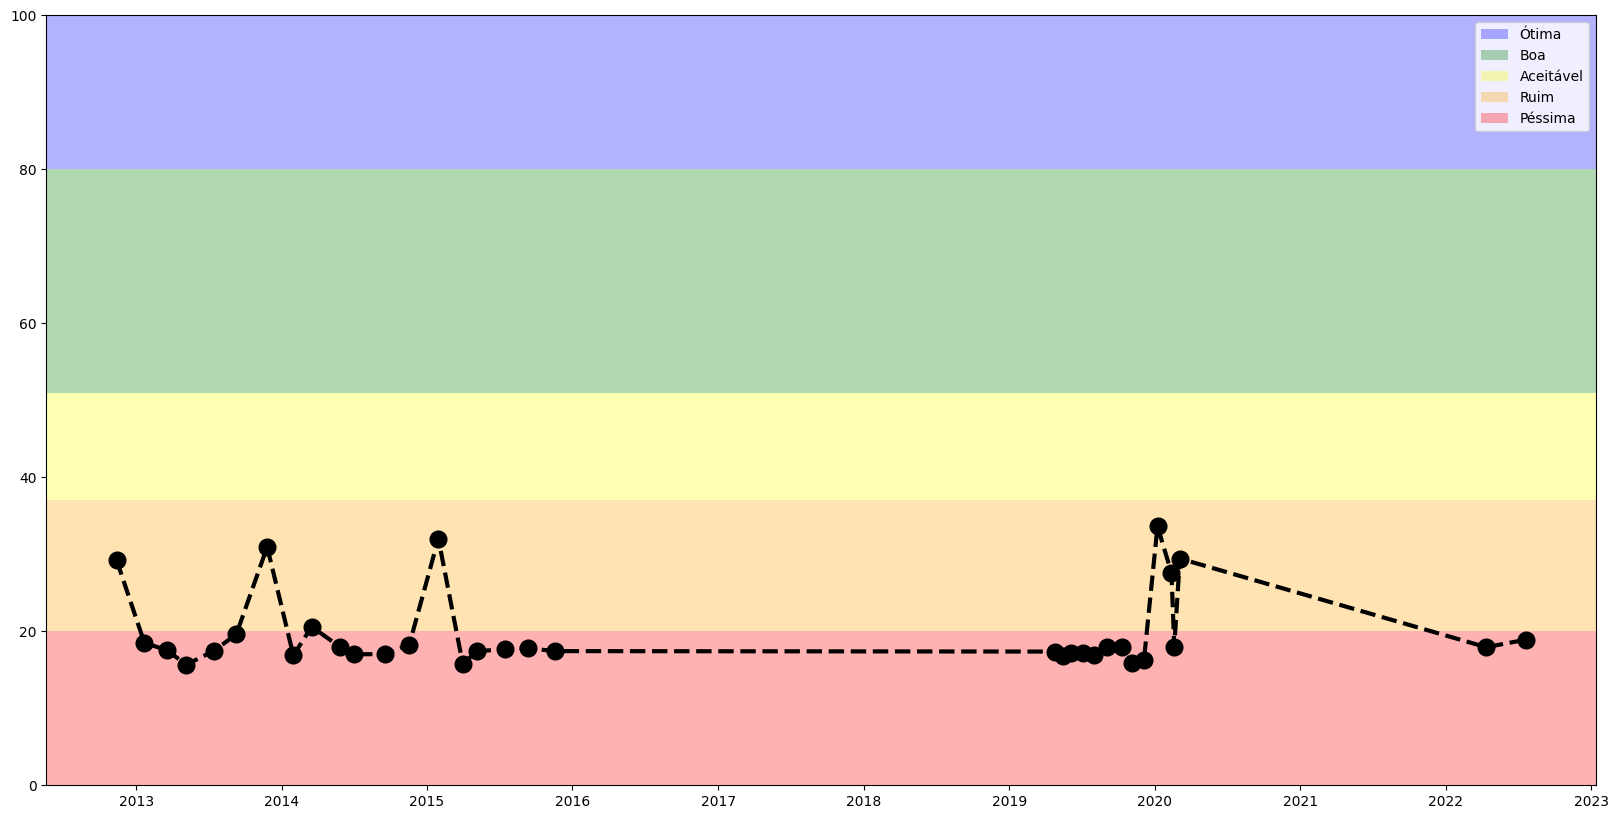

In [86]:
plt.figure(figsize=(20,10))
plt.axhspan(80, 100, facecolor='blue', alpha=0.3, label='Ótima')
plt.axhspan(51, 80, facecolor='green', alpha=0.3, label='Boa')
plt.axhspan(37, 51, facecolor='yellow', alpha=0.3, label='Aceitável')
plt.axhspan(20, 37, facecolor='orange', alpha=0.3, label='Ruim')
plt.axhspan(0, 20, facecolor='red', alpha=0.3, label='Péssima')
plt.plot(df_2012_2022_iqa["datetime"], df_2012_2022_iqa["Valor"], '--o', color='black', linewidth=3, markersize=12)
plt.ylim(0, 100)
plt.legend(loc='upper right')
plt.savefig('iqa.png', dpi=1200)
plt.show()

In [87]:
df_2012_2022_iqa.to_csv("iqa.csv")